✅ Using device: cuda
🚀 Training Started...
Epoch [1/20] D Loss: 0.9929 | G Loss: 1.9307
Epoch [2/20] D Loss: 1.0542 | G Loss: 2.3180
Epoch [3/20] D Loss: 0.9920 | G Loss: 1.3745
Epoch [4/20] D Loss: 0.9962 | G Loss: 2.3204
Epoch [5/20] D Loss: 0.7612 | G Loss: 2.0338
Epoch [6/20] D Loss: 1.3181 | G Loss: 1.4705
Epoch [7/20] D Loss: 0.6817 | G Loss: 1.7747
Epoch [8/20] D Loss: 1.0568 | G Loss: 1.1758
Epoch [9/20] D Loss: 1.0212 | G Loss: 1.6403
Epoch [10/20] D Loss: 0.8559 | G Loss: 1.6003
Epoch [11/20] D Loss: 0.9237 | G Loss: 1.5006
Epoch [12/20] D Loss: 0.8379 | G Loss: 1.5407
Epoch [13/20] D Loss: 0.9471 | G Loss: 1.0863
Epoch [14/20] D Loss: 0.9668 | G Loss: 1.3258
Epoch [15/20] D Loss: 1.0933 | G Loss: 1.5200
Epoch [16/20] D Loss: 1.1271 | G Loss: 1.7062
Epoch [17/20] D Loss: 1.0466 | G Loss: 1.9078
Epoch [18/20] D Loss: 1.3049 | G Loss: 0.8867
Epoch [19/20] D Loss: 0.9249 | G Loss: 1.3424
Epoch [20/20] D Loss: 1.1092 | G Loss: 1.7942


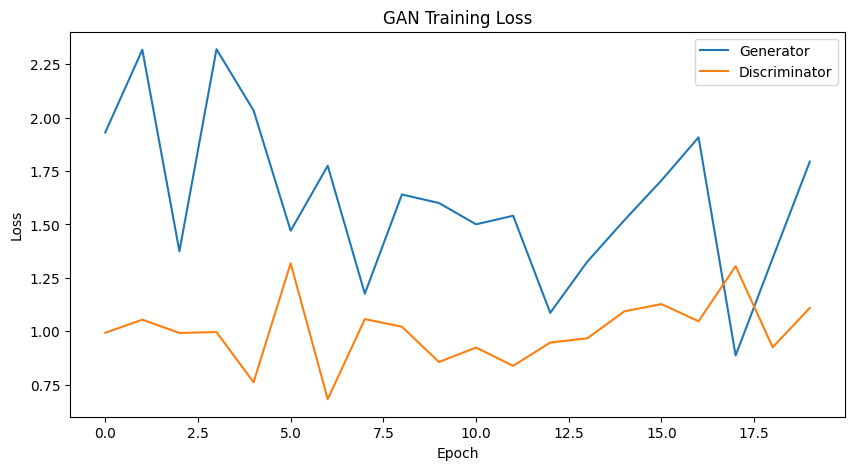

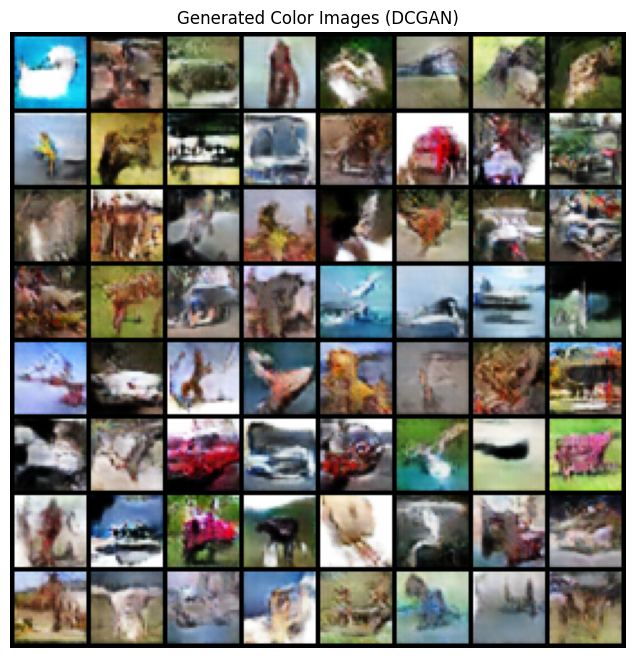

In [ ]:
import sympy
import torch
import torchvision

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

batch_size = 128
image_size = 32
nz = 100          # latent vector size (noise)
ngf = 64          # generator feature map size
ndf = 64          # discriminator feature map size
num_epochs = 20
lr = 0.0002
beta1 = 0.5

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))  # [-1, 1]
])

dataset = torchvision.datasets.CIFAR10(root='./data', download=True,
                                       transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 3, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

netG = Generator().to(device)
netD = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise for image generation preview
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

G_losses = []
D_losses = []

print("🚀 Training Started...")
for epoch in range(num_epochs):
    for i, (real, _) in enumerate(dataloader):
        real = real.to(device)
        b_size = real.size(0)
        real_label = torch.ones(b_size, device=device)
        fake_label = torch.zeros(b_size, device=device)

        # 1️⃣ Train Discriminator
        netD.zero_grad()
        output_real = netD(real)
        loss_real = criterion(output_real, real_label)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        output_fake = netD(fake.detach())
        loss_fake = criterion(output_fake, fake_label)

        D_loss = loss_real + loss_fake
        D_loss.backward()
        optimizerD.step()

        # 2️⃣ Train Generator
        netG.zero_grad()
        output = netD(fake)
        G_loss = criterion(output, real_label)
        G_loss.backward()
        optimizerG.step()

    # Track losses
    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")

plt.figure(figsize=(10,5))
plt.title("GAN Training Loss")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

with torch.no_grad():
    fake_images = netG(fixed_noise).detach().cpu()
grid = make_grid(fake_images, nrow=8, normalize=True)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Color Images (DCGAN)")
plt.imshow(grid.permute(1, 2, 0))
plt.show()
